In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/covid.csv"
data = pd.read_csv(file_path)
output_path = os.path.join("/content/drive/MyDrive/Data Science Projects/App/app/static")
os.makedirs(output_path, exist_ok=True)

In [4]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())


Data Head:
   Province/State Country/Region      Lat     Long     Date  Confirmed  Deaths  \
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0       0   
1            NaN        Albania  41.1533  20.1683  1/22/20          0       0   
2            NaN        Algeria  28.0339   1.6596  1/22/20          0       0   
3            NaN        Andorra  42.5063   1.5218  1/22/20          0       0   
4            NaN         Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  5460 non-null   object 
 1   Country/Region  17850 non-null  object 
 2   Lat             17850 non-null  float64
 3   Long            17850 non-null  float64
 4   Date            17850 non-nu

In [5]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: Province/State, Type: object, Unique values: 78
Column: Country/Region, Type: object, Unique values: 180
Column: Lat, Type: float64, Unique values: 246
Column: Long, Type: float64, Unique values: 249
Column: Date, Type: object, Unique values: 70
Column: Confirmed, Type: int64, Unique values: 1374
Column: Deaths, Type: int64, Unique values: 307
Column: Recovered, Type: int64, Unique values: 739


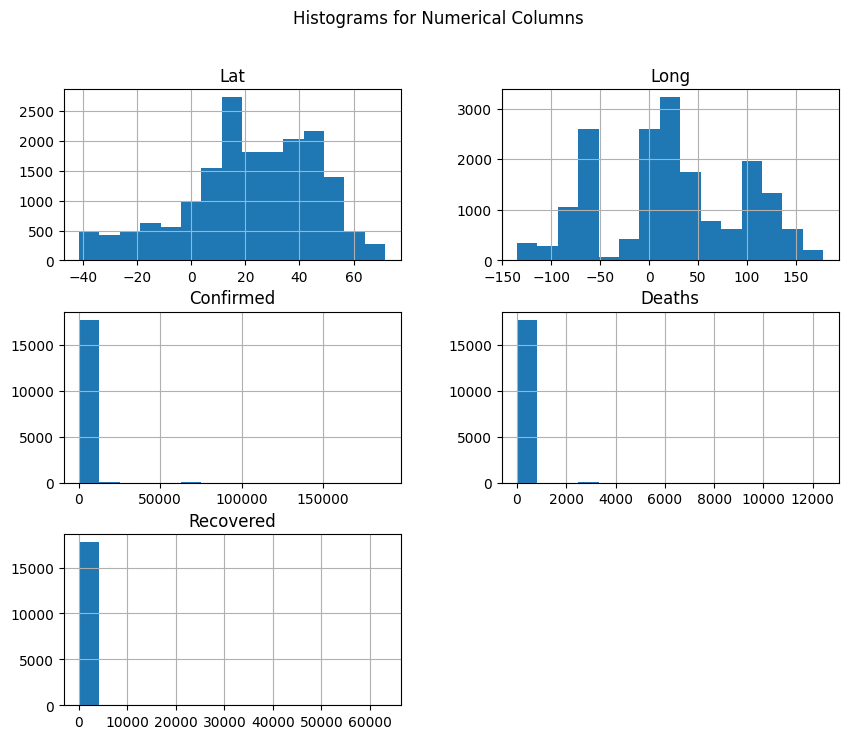

In [6]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "covid_histograms.png"))


In [7]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

Number of missing values in each column before filling:
Province/State    12390
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64


In [8]:
# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


In [9]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
Province/State: Alberta
Country/Region: China
Lat: 21.909527207843134
Long: 23.249651243137254
Date: 1/22/20
Confirmed: 594.1671148459384
Deaths: 24.313557422969186
Recovered: 172.76056022408963


In [10]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


In [ ]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"covid_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)


In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Province/State', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Province/State Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "covid_outliers_ProvinceState.png"))



In [11]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Province/State', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Province/State Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "covid_removed_outliers_ProvinceState.png"))


In [12]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['Province/State'] = label_encoder.fit_transform(data['Province/State'])


In [13]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Province/State')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Province/State':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])


In [14]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['Province/State'])  # Features
y = data['Province/State']  # Target variable

# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [16]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}


In [18]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [19]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


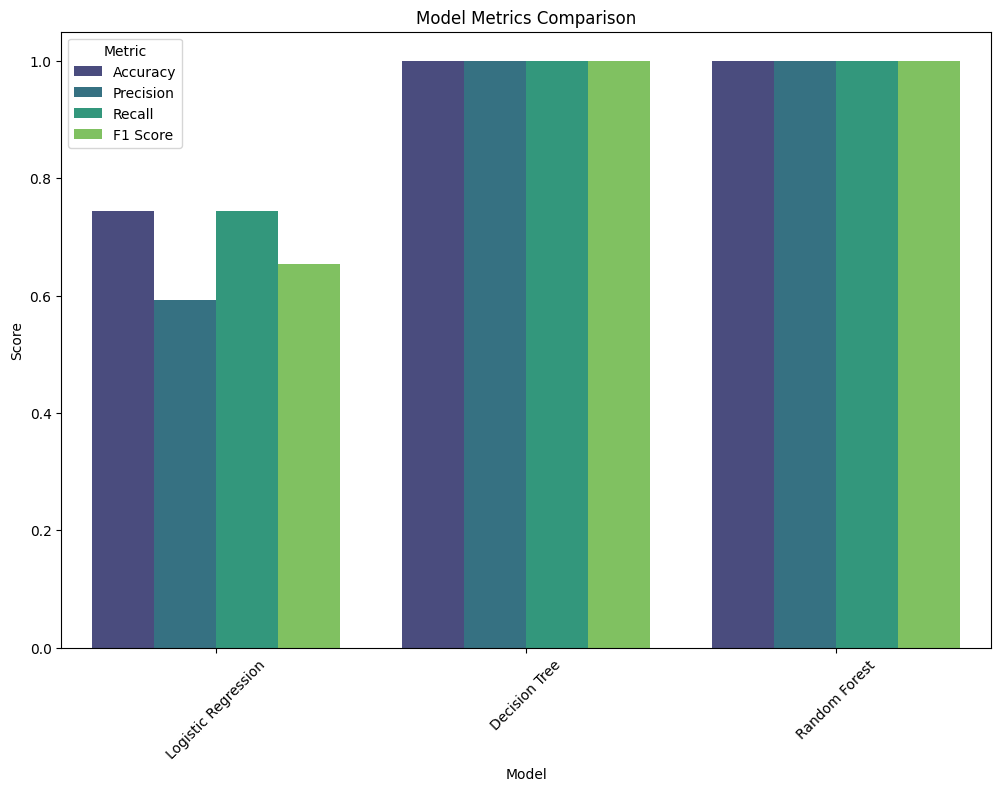

In [20]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "covid_metrics.png"))


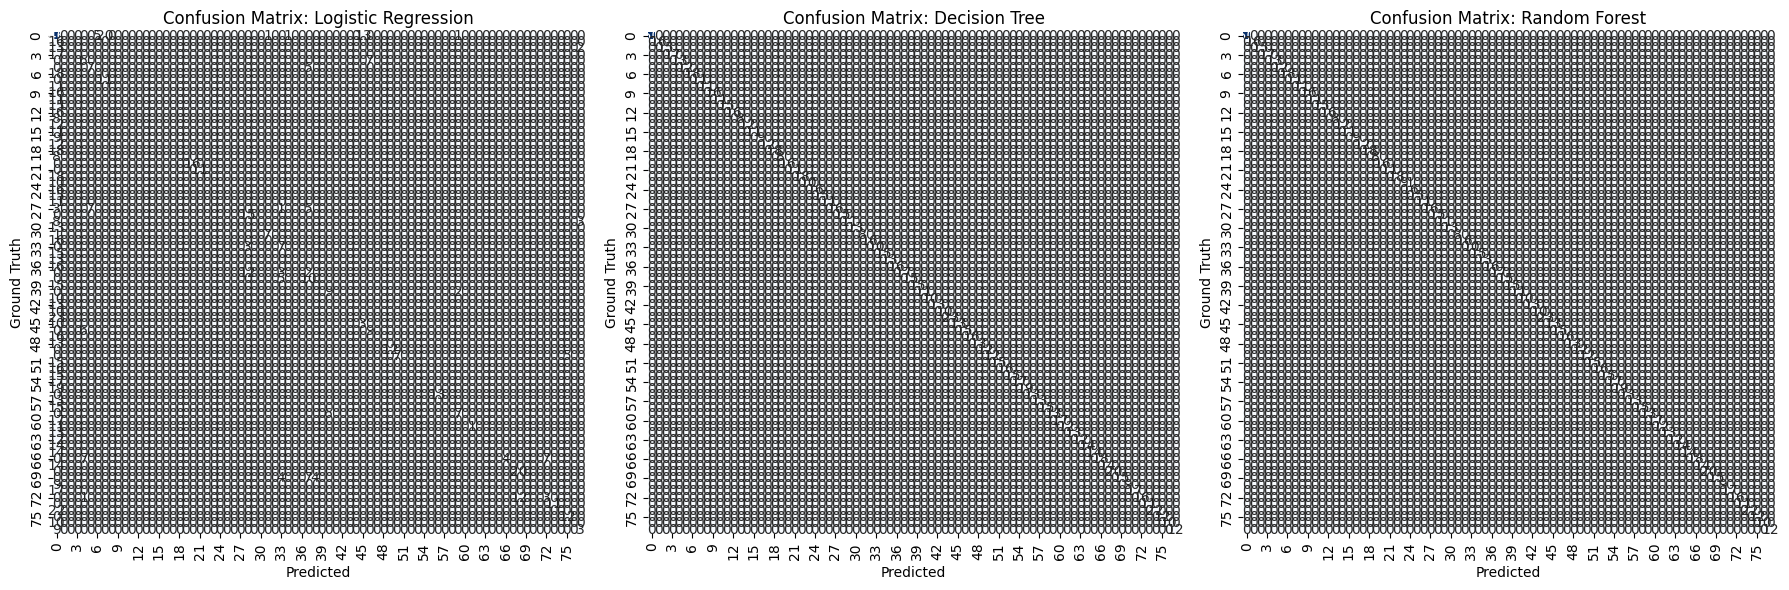

In [21]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "covid_metrix.png"))

In [22]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      2502
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        17
           4       0.30      0.46      0.36        13
           5       0.50      0.58      0.54        12
           6       0.00      0.00      0.00        18
           7       0.35      1.00      0.52        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        11
          16       0.00      0.00